In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline
from datasets import load_dataset

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import tqdm
import json
import random

In [2]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased-whole-word-masking")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-large-uncased-whole-word-masking")
pipe = pipeline("fill-mask", model="google-bert/bert-large-uncased-whole-word-masking")

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you a

In [3]:
def GetOriginalModel() -> nn.Module:
    return AutoModelForMaskedLM.from_pretrained("google-bert/bert-large-uncased-whole-word-masking")

model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

In [4]:
print("Overall parameter count:", model.num_parameters())
print("Attention weight parameter count:", 1024 * 1024 * 3 * 24)
print("Attention weight parameter ratio:", 1024 * 1024 * 3 * 24 / model.num_parameters())

Overall parameter count: 335174458
Attention weight parameter count: 75497472
Attention weight parameter ratio: 0.22524828547645478


In [5]:
weights_query_matrices = []
weights_key_matrices = []
weights_value_matrices = []

NUM_ATTENTION_LAYERS = 24

for i in tqdm.tqdm(range(NUM_ATTENTION_LAYERS)):
    weights_query_matrices.append(model.bert.encoder.layer[i].attention.self.query.weight.detach().numpy())
    weights_key_matrices.append(model.bert.encoder.layer[i].attention.self.key.weight.detach().numpy())
    weights_value_matrices.append(model.bert.encoder.layer[i].attention.self.value.weight.detach().numpy())

weights_query_variance_ratio = []
weights_key_variance_ratio = []
weights_value_variance_ratio = []

for i in tqdm.tqdm(range(NUM_ATTENTION_LAYERS)):
    weights = weights_query_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_query_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

    weights = weights_key_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_key_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

    weights = weights_value_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_value_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

  4%|▍         | 1/24 [00:52<19:59, 52.17s/it]


KeyboardInterrupt: 

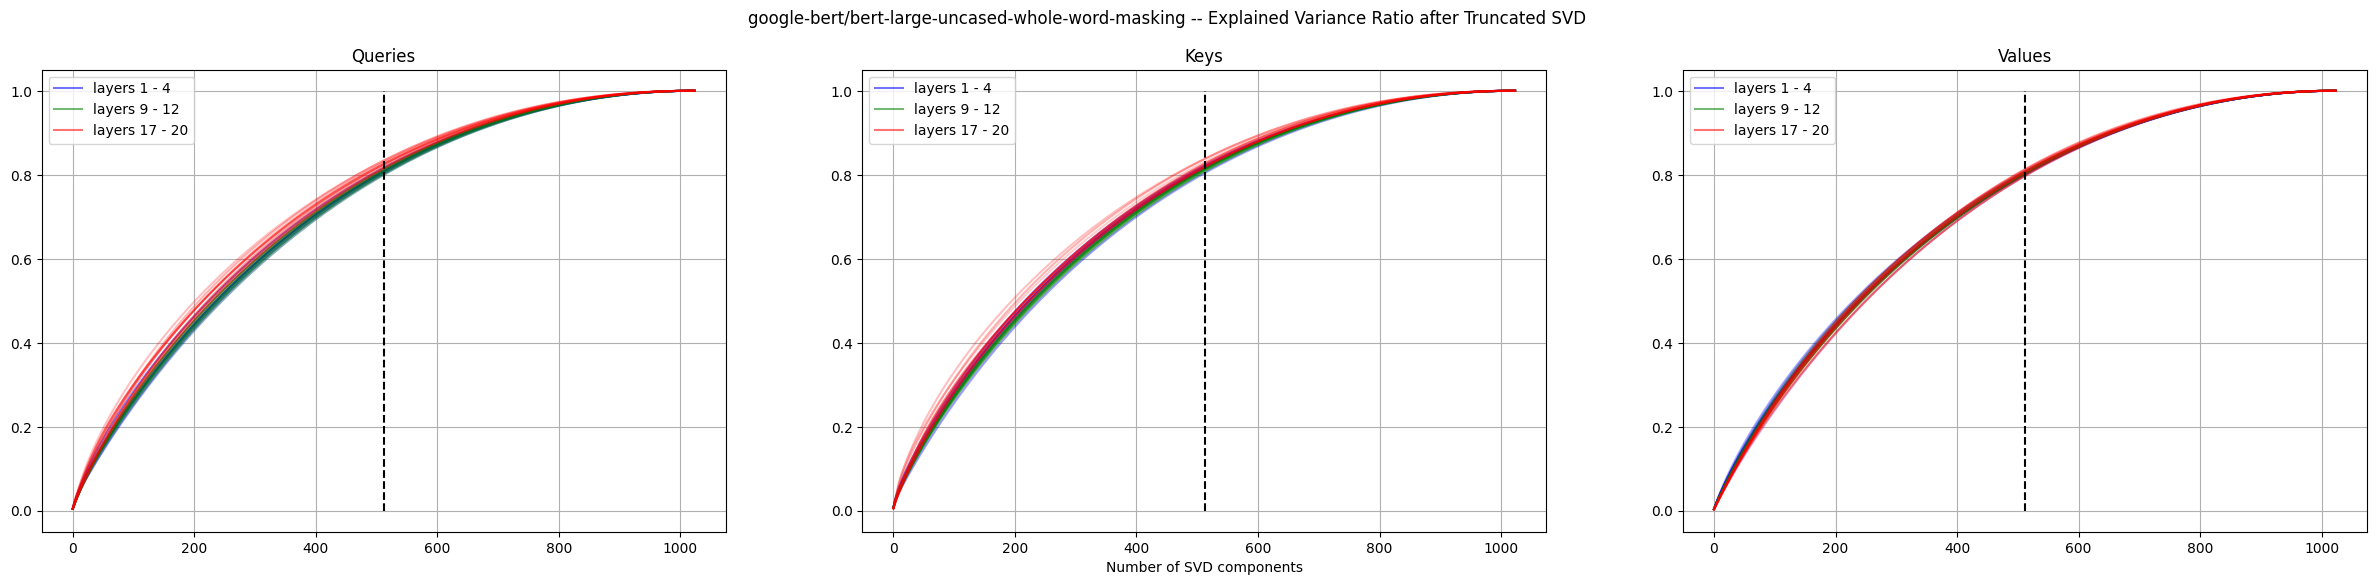

In [6]:
colors = ['blue', 'green', 'red']
titles = ['Queries', 'Keys', 'Values']

weights_variance_ratio = [weights_query_variance_ratio, weights_key_variance_ratio, weights_value_variance_ratio]

layers_per_color = 8

plt.figure(figsize=(30, 6))

for j in range(3):
    plt.subplot(1, 3, j + 1)
    for i in range(NUM_ATTENTION_LAYERS):
        if i % layers_per_color == layers_per_color - 1:
            layer_num = i // layers_per_color
            plt.plot(weights_variance_ratio[j][i], alpha=0.2 + (i % layers_per_color) * 0.05,
                     color=colors[i // layers_per_color],
                     label=f"layers {layers_per_color * layer_num + 1} - {layers_per_color * layer_num + 4}")
        else:
            plt.plot(weights_variance_ratio[j][i], alpha=0.2 + (i % layers_per_color) * 0.05, color=colors[i // layers_per_color])

    plt.vlines(len(weights_variance_ratio[0][0]) // 2, ymin=0, ymax=1, linestyle='--', color='black')

    plt.title(titles[j])
    plt.legend()
    plt.grid()

    if j == 1:
        plt.xlabel('Number of SVD components')

plt.suptitle('google-bert/bert-large-uncased-whole-word-masking -- Explained Variance Ratio after Truncated SVD')

plt.show()

In [5]:
dataset = load_dataset("nyu-mll/multi_nli")

In [6]:
dataset = dataset['validation_matched']

In [7]:
model.eval()


def mask_tokens(text, mask_prob=0.1):
    tokens = tokenizer.tokenize(text)
    masked_tokens = tokens.copy()
    masked_originals = []
    for i in range(min(len(tokens), 512)):
        if random.random() < mask_prob and tokens[i] not in tokenizer.all_special_tokens and len(masked_originals) < 5:
            masked_tokens[i] = "[MASK]"
            masked_originals.append(tokens[i])
    return masked_tokens, masked_originals


def evaluate_mask_filling(dataset, device):
    correct = 0
    total = 0
    model.to(device)

    for example in tqdm.tqdm(dataset):
        text = example['premise'].strip()

        masked_tokens, masked_originals = mask_tokens(text)
        if not masked_originals:
            continue

        masked_text = " ".join(masked_tokens)
        outputs = pipe(masked_text)
        if not isinstance(outputs[0], list):
            outputs = [outputs]

        for j, original_token in enumerate(masked_originals):
            for word in outputs[j]:
                if word['token_str'] == original_token:
                    correct += 1
                total += 1

    accuracy = correct * 5 / total if total > 0 else 0
    return {"mask_filling_accuracy": accuracy, "total_predictions": total, "nun_parameters": model.num_parameters()}


#results = evaluate_mask_filling(dataset)
#print("Evaluation results:", results)

In [12]:
with open('bert-accuracy-scores/original_model.json', 'w') as file:
    json.dump(results, file, indent=4)

In [8]:
class TruncatedSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: torch.Tensor, bias: torch.Tensor, device: torch.device = torch.device('cpu')):
        super().__init__()
        U, Sigma, V = torch.linalg.svd(weight, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = torch.diag(Sigma[:min(rank, max_rank)])
        U = U[:, :min(rank, max_rank)] @ SigmaDiag
        V = V[:min(rank, max_rank), :]

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(U)
        self.U.bias.data.copy_(bias)
        self.V.weight.data.copy_(V)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'

In [9]:
def MakeModifiedModel(
    model: nn.Module,
    max_rank: int,
    max_layer: int,
    all_layers: int,
    device: torch.device = torch.device('cpu'),
) -> nn.Module:
    for i in range(min(max_layer, all_layers)):
        print(i)
        model.bert.encoder.layer[i].attention.self.query = TruncatedSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.query.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.query.bias.detach(),
            device=device
        )
        model.bert.encoder.layer[i].attention.self.key = TruncatedSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.key.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.key.bias.detach(),
            device=device
        )
        model.bert.encoder.layer[i].attention.self.value = TruncatedSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.value.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.value.bias.detach(),
            device=device
        )

    return model.to(device)


def MakeModifiedPipe(max_rank: int, max_layer: int, all_layers: int, device: torch.device) -> pipeline:
    pipe_modified = pipeline(
        "fill-mask",
        model=MakeModifiedModel(GetOriginalModel(), max_rank, max_layer, all_layers, device),
        tokenizer=tokenizer,
        device=device
    )
    return pipe_modified

In [10]:
def evaluate_piped_mask_filling(pipeline, dataset, device):
    correct = 0
    total = 0
    model.to(device)
    #dataset = dataset.to(device)

    for example in tqdm.tqdm(dataset):
        text = example['premise'].strip()

        masked_tokens, masked_originals = mask_tokens(text)
        if not masked_originals:
            continue

        masked_text = " ".join(masked_tokens)
        outputs = pipeline(masked_text)
        if not isinstance(outputs[0], list):
            outputs = [outputs]

        for j, original_token in enumerate(masked_originals):
            for word in outputs[j]:
                if word['token_str'] == original_token:
                    correct += 1
                total += 1

    accuracy = correct * 5 / total if total > 0 else 0
    return {"mask_filling_accuracy": accuracy, "total_predictions": total, "nun_parameters": model.num_parameters()}

In [11]:
max_rank = 256
NUM_ATTENTION_LAYERS = 24
all_layers = NUM_ATTENTION_LAYERS

In [65]:
for max_layer in range(10, 25, 2):
    print(f'max_layer#{max_layer}')
    device = torch.device('cuda:0')
    model = GetOriginalModel()
    modified_model = MakeModifiedModel(model, max_rank, max_layer, all_layers, device)
    pipe_modified = pipeline(
        "fill-mask",
        model=modified_model,
        tokenizer=tokenizer,
        device=device
    )

    print(f'pipeline#{max_layer}')
    results = evaluate_piped_mask_filling(pipe_modified, dataset, device)
    print(f'results#{max_layer}')
    with open(f'bert-accuracy-scores/truncated-model-256-{max_layer}.json', 'w') as file:
        json.dump(results, file, indent=4)

max_layer#10


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9


Device set to use cuda:0


pipeline#10


100%|██████████| 9815/9815 [03:55<00:00, 41.70it/s]


results#10
max_layer#12


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11


Device set to use cuda:0


pipeline#12


100%|██████████| 9815/9815 [04:01<00:00, 40.63it/s]


results#12
max_layer#14


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13


Device set to use cuda:0


pipeline#14


100%|██████████| 9815/9815 [04:01<00:00, 40.72it/s]


results#14
max_layer#16


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Device set to use cuda:0


pipeline#16


100%|██████████| 9815/9815 [03:56<00:00, 41.46it/s]


results#16
max_layer#18


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Device set to use cuda:0


pipeline#18


100%|██████████| 9815/9815 [04:02<00:00, 40.42it/s]


results#18
max_layer#20


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Device set to use cuda:0


pipeline#20


100%|██████████| 9815/9815 [04:14<00:00, 38.56it/s]


results#20
max_layer#22


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Device set to use cuda:0


pipeline#22


100%|██████████| 9815/9815 [04:17<00:00, 38.05it/s]


results#22
max_layer#24


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Device set to use cuda:0


pipeline#24


100%|██████████| 9815/9815 [04:09<00:00, 39.26it/s]

results#24


In [11]:
max_rank = 128
NUM_ATTENTION_LAYERS = 24
all_layers = NUM_ATTENTION_LAYERS

for max_layer in range(24, 25, 2):
    print(f'max_layer#{max_layer}')
    device = torch.device('cuda:0')
    model = GetOriginalModel()
    modified_model = MakeModifiedModel(model, max_rank, max_layer, all_layers, device)
    pipe_modified = pipeline(
        "fill-mask",
        model=modified_model,
        tokenizer=tokenizer,
        device=device
    )

    print(f'pipeline#{max_layer}')
    results = evaluate_piped_mask_filling(pipe_modified, dataset, device)
    print(f'results#{max_layer}')
    with open(f'bert-accuracy-scores/truncated-model-128-{max_layer}.json', 'w') as file:
        json.dump(results, file, indent=4)

max_layer#24


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0


KeyboardInterrupt: 

In [12]:
model = GetOriginalModel()
model.eval()

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

In [13]:
attention_layers_preactivations = dict()

def make_forward_pre_hook(module_str: str):
    def forward_pre_hook(module: torch.nn.Module, input):
        x = input[0]
        if module_str not in attention_layers_preactivations:
            attention_layers_preactivations[module_str] = []

        attention_layers_preactivations[module_str].append(x.detach().clone().cpu())

    return forward_pre_hook

def make_tokenization(text):
    return tokenizer.tokenize(text)

handlers = []

for i in range(NUM_ATTENTION_LAYERS):
    handler = model.bert.encoder.layer[i].attention.self.query.register_forward_pre_hook(
        make_forward_pre_hook(f'{i}/query')
    )
    handlers.append(handler)
    handler = model.bert.encoder.layer[i].attention.self.value.register_forward_pre_hook(
        make_forward_pre_hook(f'{i}/value')
    )
    handlers.append(handler)
    handler = model.bert.encoder.layer[i].attention.self.key.register_forward_pre_hook(
        make_forward_pre_hook(f'{i}/key')
    )
    handlers.append(handler)


samples_count = 0
device = torch.device('cuda:0')

for example in dataset:
    text = example['premise'].strip()
    text_tokens = make_tokenization(text)

    if len(text_tokens) >= 128:
        text_tokens = text_tokens[:128]
        samples_count += 1
        shrinked_text = ' '.join(text_tokens)
        print(shrinked_text)

        output_tokens = tokenizer(shrinked_text, return_tensors="pt")

        model(**output_tokens)

        if samples_count == 10:
            break

well the first thing for me is i wonder i see a couple of different ways of talking about what privacy is um if privacy is something that disturb ##s your private state i mean an invasion of privacy is something that disturb ##s your private state that ' s one thing and if privacy is something that comes into your private state and extracts information from it in other words finds something out about you that ' s another and the first kind of invasion of the first type of privacy seems invaded to me in very much everyday in this country but in the second type at least over ##tly uh where someone comes in and uh finds out information about you that should be private
yeah because you look at the statistics now and i ' m sure it ' s in your your newspapers just like it is in ours that every major city now the increase of crime is is es ##cala ##ting i mean there are more look at the look at the people there are being shot now i mean every day there ' s there ' s dozens of dozens of people

In [14]:
for handler in handlers:
    handler.remove()

In [15]:
attention_layers_preactivations_concat = dict()

for layer_num in range(NUM_ATTENTION_LAYERS):
    for layer_type in ['key', 'value', 'query']:
        attention_layers_preactivations_concat[f'{layer_num}/{layer_type}'] = torch.concat(
            attention_layers_preactivations[f'{layer_num}/{layer_type}'],
            dim=1
        ).transpose(2, 0).squeeze()


In [24]:
class TruncatedAdaptiveSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: torch.Tensor, bias: torch.Tensor,
                 precondtioner: torch.Tensor, inv_preconditioner: torch.Tensor,
                 device: torch.device = torch.device('cpu')):
        super().__init__()
        U, Sigma, V = torch.linalg.svd(weight @ precondtioner, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = torch.diag(Sigma[:min(rank, max_rank)])
        U = U[:, :min(rank, max_rank)] @ SigmaDiag
        V = V[:min(rank, max_rank), :] @ inv_preconditioner

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(U)
        self.U.bias.data.copy_(bias)
        self.V.weight.data.copy_(V)
        self.U = self.U.to(device)
        self.V = self.V.to(device)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'

In [25]:
def MakeModifiedAdaptiveModel(
    model: nn.Module,
    max_rank: int,
    max_layer: int,
    all_layers: int,
    device: torch.device = torch.device('cpu'),
) -> nn.Module:
    for i in range(min(max_layer, all_layers)):
        print(i)
        activations = torch.mean(torch.abs(attention_layers_preactivations_concat[f'{i}/query']), dim=1)**0.5
        model.bert.encoder.layer[i].attention.self.query = TruncatedAdaptiveSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.query.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.query.bias.detach(),
            precondtioner=torch.diag(activations),
            inv_preconditioner=torch.diag(1 / activations),
            device=device
        )

        activations = torch.mean(torch.abs(attention_layers_preactivations_concat[f'{i}/key']), dim=1)**0.5
        model.bert.encoder.layer[i].attention.self.key = TruncatedAdaptiveSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.key.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.key.bias.detach(),
            precondtioner=torch.diag(activations),
            inv_preconditioner=torch.diag(1 / activations),
            device=device
        )

        activations = torch.mean(torch.abs(attention_layers_preactivations_concat[f'{i}/value']), dim=1)**0.5
        model.bert.encoder.layer[i].attention.self.value = TruncatedAdaptiveSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.value.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.value.bias.detach(),
            precondtioner=torch.diag(activations),
            inv_preconditioner=torch.diag(1 / activations),
            device=device
        )

    return model.to(device)


def MakeModifiedAdaptivePipe(max_rank: int, max_layer: int, all_layers: int, device: torch.device) -> pipeline:
    pipe_modified = pipeline(
        "fill-mask",
        model=MakeModifiedAdaptiveModel(GetOriginalModel(), max_rank, max_layer, all_layers, device),
        tokenizer=tokenizer,
        device=device
    )
    return pipe_modified

In [26]:
max_rank = 256
NUM_ATTENTION_LAYERS = 24
all_layers = NUM_ATTENTION_LAYERS

for max_layer in range(2, 25, 2):
    print(f'max_layer#{max_layer}')
    device = torch.device('cuda:0')
    model = GetOriginalModel()
    modified_model = MakeModifiedAdaptiveModel(model, max_rank, max_layer, all_layers, device)
    pipe_modified = pipeline(
        "fill-mask",
        model=modified_model,
        tokenizer=tokenizer,
        device=device
    )

    print(f'pipeline#{max_layer}')
    results = evaluate_piped_mask_filling(pipe_modified, dataset, device)
    print(f'results#{max_layer}')
    with open(f'bert-accuracy-scores/truncated-model-adaptive-256-{max_layer}.json', 'w') as file:
        json.dump(results, file, indent=4)

max_layer#2


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1


Device set to use cuda:0


pipeline#2


100%|██████████| 9815/9815 [06:49<00:00, 23.98it/s]


results#2
max_layer#4


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3


Device set to use cuda:0


pipeline#4


100%|██████████| 9815/9815 [05:18<00:00, 30.81it/s]


results#4
max_layer#6


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5


Device set to use cuda:0


pipeline#6


100%|██████████| 9815/9815 [05:20<00:00, 30.65it/s]


results#6
max_layer#8


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7


Device set to use cuda:0


pipeline#8


100%|██████████| 9815/9815 [05:27<00:00, 29.94it/s]


results#8
max_layer#10


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9


Device set to use cuda:0


pipeline#10


100%|██████████| 9815/9815 [06:30<00:00, 25.12it/s]


results#10
max_layer#12


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11


Device set to use cuda:0


pipeline#12


100%|██████████| 9815/9815 [05:36<00:00, 29.14it/s]


results#12
max_layer#14


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13


Device set to use cuda:0


pipeline#14


100%|██████████| 9815/9815 [05:19<00:00, 30.70it/s]


results#14
max_layer#16


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Device set to use cuda:0


pipeline#16


100%|██████████| 9815/9815 [05:29<00:00, 29.83it/s]


results#16
max_layer#18


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Device set to use cuda:0


pipeline#18


100%|██████████| 9815/9815 [05:14<00:00, 31.25it/s]


results#18
max_layer#20


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Device set to use cuda:0


pipeline#20


100%|██████████| 9815/9815 [05:16<00:00, 31.04it/s]


results#20
max_layer#22


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Device set to use cuda:0


pipeline#22


100%|██████████| 9815/9815 [05:27<00:00, 29.94it/s]


results#22
max_layer#24


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Device set to use cuda:0


pipeline#24


100%|██████████| 9815/9815 [05:04<00:00, 32.26it/s]

results#24


In [ ]:
max_rank = 128
NUM_ATTENTION_LAYERS = 24
all_layers = NUM_ATTENTION_LAYERS

for max_layer in range(4, 25, 4):
    print(f'max_layer#{max_layer}')
    device = torch.device('cuda:0')
    model = GetOriginalModel()
    modified_model = MakeModifiedAdaptiveModel(model, max_rank, max_layer, all_layers, device)
    pipe_modified = pipeline(
        "fill-mask",
        model=modified_model,
        tokenizer=tokenizer,
        device=device
    )

    print(f'pipeline#{max_layer}')
    results = evaluate_piped_mask_filling(pipe_modified, dataset, device)
    print(f'results#{max_layer}')
    with open(f'bert-accuracy-scores/truncated-model-adaptive-128-{max_layer}.json', 'w') as file:
        json.dump(results, file, indent=4)

max_layer#4


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3


Device set to use cuda:0


pipeline#4


100%|██████████| 9815/9815 [02:48<00:00, 58.25it/s]


results#4
max_layer#8


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7


Device set to use cuda:0


pipeline#8


100%|██████████| 9815/9815 [02:55<00:00, 55.82it/s]


results#8
max_layer#12


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11


Device set to use cuda:0


pipeline#12


100%|██████████| 9815/9815 [03:09<00:00, 51.79it/s]


results#12
max_layer#16


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Device set to use cuda:0


pipeline#16


100%|██████████| 9815/9815 [03:08<00:00, 52.15it/s]


results#16
max_layer#20


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Device set to use cuda:0


pipeline#20


100%|██████████| 9815/9815 [03:04<00:00, 53.33it/s]


results#20
max_layer#24


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Device set to use cuda:0


pipeline#24


100%|██████████| 9815/9815 [03:05<00:00, 52.91it/s]

results#24


In [ ]:
accuracy_scores_256 = []
accuracy_scores_128 = []
parameters_ratio_256 = []
parameters_ratio_128 = []

accuracy_scores_adaptive_256 = []
accuracy_scores_adaptive_128 = []
parameters_ratio_adaptive_256 = []
parameters_ratio_adaptive_128 = []

model = GetOriginalModel()

for i in range(0, 25, 2):
    with open(f'bert-accuracy-scores/truncated-model-256-{i}.json', 'r') as file:
        model_parameters = json.load(file)
        accuracy_scores_256.append(model_parameters['mask_filling_accuracy'])
        parameters_ratio_256.append(model_parameters['nun_parameters'] / model.num_parameters())
    with open(f'bert-accuracy-scores/truncated-model-128-{i}.json', 'r') as file:
        model_parameters = json.load(file)
        accuracy_scores_128.append(model_parameters['mask_filling_accuracy'])
        parameters_ratio_128.append(model_parameters['nun_parameters'] / model.num_parameters())
    if i % 4 == 2:
        with open(f'bert-accuracy-scores/truncated-model-adaptive-256-{i}.json', 'r') as file:
            model_parameters = json.load(file)
            accuracy_scores_adaptive_256.append(model_parameters['mask_filling_accuracy'])
            parameters_ratio_adaptive_256.append(model_parameters['nun_parameters'] / model.num_parameters())
    if i % 4 == 0:
        with open(f'bert-accuracy-scores/truncated-model-adaptive-128-{i}.json', 'r') as file:
            model_parameters = json.load(file)
            accuracy_scores_adaptive_128.append(model_parameters['mask_filling_accuracy'])
            parameters_ratio_adaptive_128.append(model_parameters['nun_parameters'] / model.num_parameters())


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


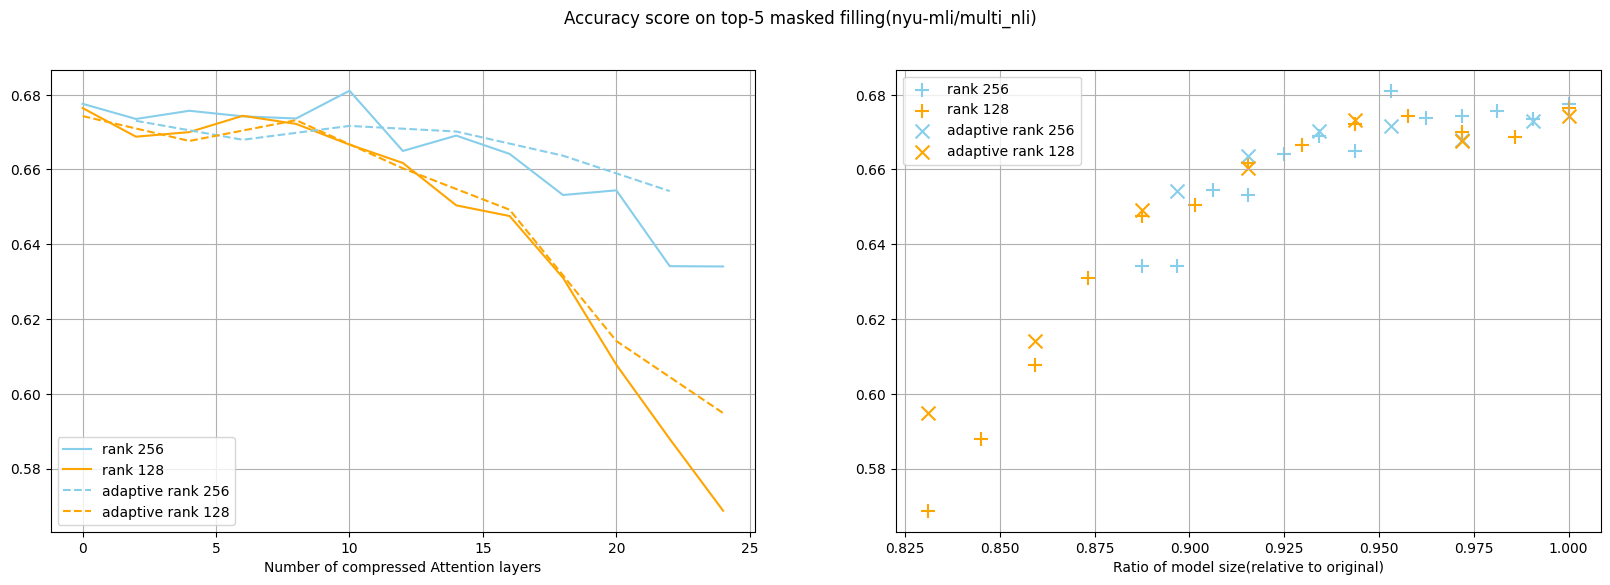

In [52]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 25, 2), accuracy_scores_256, color='skyblue', label='rank 256')
plt.plot(np.arange(0, 25, 2), accuracy_scores_128, color='orange', label='rank 128')
plt.plot(np.arange(2, 25, 4), accuracy_scores_adaptive_256, color='skyblue', linestyle='--', label='adaptive rank 256')
plt.plot(np.arange(0, 25, 4), accuracy_scores_adaptive_128, color='orange', linestyle='--', label='adaptive rank 128')
plt.xlabel('Number of compressed Attention layers')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(parameters_ratio_256,accuracy_scores_256, marker='+', color='skyblue', s=100, label='rank 256')
plt.scatter(parameters_ratio_128, accuracy_scores_128, marker='+', color='orange', s=100, label='rank 128')
plt.scatter(parameters_ratio_adaptive_256, accuracy_scores_adaptive_256, marker='x', color='skyblue', s=100, label='adaptive rank 256')
plt.scatter(parameters_ratio_adaptive_128, accuracy_scores_adaptive_128, marker='x', color='orange', s=100, label='adaptive rank 128')
plt.xlabel('Ratio of model size(relative to original)')
plt.legend()
plt.grid()

plt.suptitle('Accuracy score on top-5 masked filling(nyu-mli/multi_nli)')
plt.show()